In [1]:
# VClamp SCN2A Variants
# Generates simulated data for Na1.2 channel
# Hidden Markov Model
 
# Modified from Emilio Andreozzi "Phenomenological models of NaV1.5.
    # A side by side, procedural, hands-on comparison between
    # Hodgkin-Huxley and kinetic formalisms." 2019
# Contributors: Emily Nguyen UC Berkeley, Roy Ben-Shalom UCSF
 
from neuron import h, gui
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.cm as cmx
from scipy import optimize, stats
 
##################
# Activation Na 1.2 
##################e
 
# Args: String command
# Calls activationNa12 plotting function when command == "plotActivation"
# Calls activationNa12 data generating function when command == "genActivation"
# Returns h (<TopLevelHocInterpreter>) when command == "geth"
# genActivation Returns vector for peak currents (NOT normalized)
def activationNa12(command):
 
    dtype = np.float64
 
    # one-compartment cell (soma)
    soma        = h.Section(name='soma')
     
    soma.diam   = 50        # micron
    soma.L      = 63.66198  # micron, so that area = 10000 micron2
    soma.nseg   = 1         # adimensional
    soma.cm     = 1         # uF/cm2
    soma.Ra     = 70        # ohm-cm
 
    soma.nseg   = 1
    soma.insert('na15')     #insert mechanism ('na12mut')
    soma.ena    = 65        # na12_mut prev value = 55
    h.celsius   = 24        # temperature in celsius   # na12_mut prev value = 33
    v_init      = -120      # holding potential
    h.dt        = 0.025      # ms - value of the fundamental integration time step, dt, used by fadvance().
 
    # clamping parameters
    dur         = 500        # clamp duration, ms =20
    step        = 10         # voltage clamp increment, the user can =2
    st_cl       = -120       # clamp start, mV =-90
    end_cl      = 40        # clamp end, mV    =11
    v_cl        = -120       # actual voltage clamp, mV =-90
 
    # a electrode voltage clamp
    f3cl = h.VClamp(soma(0.5))
    f3cl.dur[0] = 5       # ms
    f3cl.amp[0] = -120    # mV 
    f3cl.dur[1] = dur     # ms
    f3cl.amp[1] = v_cl    # mV
    f3cl.dur[2] = 5       # ms 
    f3cl.amp[2] = -120    # mV 

    # finding the "initial state variables values" # HMM
    from state_variables import finding_state_variables
    initial_values = [x for x in finding_state_variables(v_init,h.celsius)]
    #print('Initial values [C1, C2, O1, I1, I2]=  ', initial_values)
    for seg in soma:
        seg.na15.iC1=initial_values[0]
        seg.na15.iC2=initial_values[1]
        seg.na15.iO1=initial_values[2]
        seg.na15.iI1=initial_values[3]
        seg.na15.iI2=initial_values[4]
 
    #number of elements of the vector containing the values from st_cl to end_cl with the fixed step
    L=len(np.arange(st_cl, end_cl, step))
 
    # vectors for data handling
    t_vec       = h.Vector()  # vector for time
    v_vec       = h.Vector()  # vector for voltage
    v_vec_t     = h.Vector()  # vector for voltage as function of time
    i_vec       = h.Vector()  # vector for current 
    ipeak_vec   = h.Vector()  # vector for peak current
    gpeak_vec   = h.Vector()  # vector for peak conductance
    gnorm_vec   = h.Vector()  # vector for normalized conductance
    all_is = []
 
    # clamping definition
    def clamp(v_cl):
 
        curr_tr = 0  # initialization of peak current
        cond_tr = 0  # initialization of peak conductance
 
        h.finitialize(v_init) # calling the INITIAL block of the mechanism inserted in the section.
 
        # initialization of variables used to commute the peak current and conductance    
        pre_i  = 0    
        dens   = 0
 
        f3cl.amp[1] = v_cl    # mV
 
        for j in range(30):
 
            while (h.t<h.tstop): # runs a single trace, calculates peak current
                dens = f3cl.i/soma(0.5).area()*100.0-soma(0.5).i_cap # clamping current in mA/cm2, for each dt
 
                t_vec.append(h.t)       # code for storing the current
                v_vec_t.append(soma.v)  # trace to be plotted
                i_vec.append(dens)      # trace to be plotted
 
                if ((h.t>5)and(h.t<=10)):       # evaluate the peak 
                    if(abs(dens)>abs(pre_i)):
                        cond_tr = soma.g_na15   # updates the peak conductance #Modify RHS as needed for different channels
                        curr_tr = dens          # updates the peak current
 
 
                h.fadvance()
                pre_i = dens
 
        # updates the vectors at the end of the run        
        v_vec.append(v_cl)              
        gpeak_vec.append(cond_tr)
        ipeak_vec.append(curr_tr)
 
 
    ### start program and plots
    def plotActivation():
 
        # figure definition
        #fig, ax     = plt.subplots(1, 3,figsize=(18,6))  
 
        fig = plt.figure(figsize=(20,15))
        ax1 = plt.subplot2grid((2,4), (0, 0), colspan=2)
 
        fig.subplots_adjust(wspace=0.5)
 
        ax1.set_xlim(-100,40)
        ax1.set_ylim(-0.05,1.05)        
        ax1.set_xlabel('Voltage $(mV)$')
        ax1.set_ylabel('Normalized conductance')
        ax1.set_title('Activation Na1.2: Voltage/Normalized conductance')
 
        h.tstop = 5 + dur + 5       # time stop
 
        # resizing the vectors
        v_vec.resize(0)          
        gpeak_vec.resize(0)
        ipeak_vec.resize(0)
 
        k=0     # counter
        for v_cl in np.arange(st_cl, end_cl, step): # iterates across voltages
 
                # resizing the vectors
                t_vec.resize(0)  
                i_vec.resize(0) 
                v_vec_t.resize(0) 
 
 
                clamp(v_cl)
                k=k+1
                all_is.append(i_vec)
 
        gpeak_max = gpeak_vec.max()           # maximum value of the conductance used to normalize the conductance vector
        for i in range(0, len(gpeak_vec), 1):
 
             gnorm_vec.append(gpeak_vec.x[i]/gpeak_max) # normalization of peak conductance
             ln2,=ax1.plot(v_vec.x[i], gnorm_vec.x[i], 'o', c='black')
 
        plt.show()
        return all_is
 
    # Generates simulated activation data
    # Returns peak current vector
    def genActivation():
        h.tstop = 5 + dur + 5       # time stop
 
        # resizing the vectors
        v_vec.resize(0)          
        gpeak_vec.resize(0)
        ipeak_vec.resize(0)
 
        k=0     # counter
        for v_cl in np.arange(st_cl, end_cl, step): # iterates across voltages
 
                # resizing the vectors
                t_vec.resize(0)  
                i_vec.resize(0) 
                v_vec_t.resize(0) 
 
        
                clamp(v_cl)
                k=k+1
                aa = i_vec.to_python()
                all_is.append(aa[1:])
 
        gpeak_max = gpeak_vec.max()           # maximum value of the conductance used to normalize the conductance vector
        for i in range(0, len(gpeak_vec), 1):
             gnorm_vec.append(gpeak_vec.x[i]/gpeak_max) # normalization of peak conductance
         
        return gnorm_vec, np.arange(st_cl, end_cl, step),all_is
 
    #Command Processor
    if command == "plotActivation":
        return plotActivation()
    elif command == "genActivation":
        return genActivation()
    elif command == "geth":
        return h
    else:
        print("Invalid command. Function does not exist.")
 
##################
# Inactivation Na 1.2 
##################
 
# Args: String command
# Calls inactivationNa12 plotting function when command == "plotInactivation"
# Calls inactivationNa12 data generating function when command == "genInactivation"
# genInactivation Returns vector for normalized current
def inactivationNa12(command):
    dtype = np.float64
 
    # one-compartment cell (soma)
    soma        = h.Section(name='soma')
    soma.diam   = 50         # micron
    soma.L      = 63.66198   # micron, so that area = 10000 micron2
    soma.nseg   = 1          # adimensional
    soma.cm     = 1          # uF/cm2
    soma.Ra     = 70         # ohm-cm
 
    soma.nseg   = 1
    soma.insert('na15')      # insert mechanism ('na12mut')
    soma.ena    = 55         # na12_mut previous value = 55
    h.celsius   = 24         # temperature in celsius Na1.2 value  # na12_mut prev value= 33
    v_init      = -120       # holding potential   
    h.dt        = 0.025       # ms - value of the fundamental integration time step, dt, used by fadvance().
 
    # clamping parameters
    dur         = 500        # clamp duration, ms Na1.5 value = 500
    step        = 10          # voltage clamp increment, Na1.5 value = 3
    st_cl       = -120       # clamp start, mV, Na1.5 value = -120
    end_cl      = 40          # clamp end, mV, Na1.5 value = 1
    v_cl        = -120       # actual voltage clamp, mV, Na1.5 value  = -120
 
    #number of elements of the vector containing the values from st_cl to end_cl with the fixed step
    L=len(np.arange(st_cl, end_cl, step))
 
    # vectors for data handling
    t_vec       = h.Vector() # vector for time 
    v_vec       = h.Vector() # vector for voltage
    v_vec_t     = h.Vector() # vector for voltage as function of time
    i_vec       = h.Vector() # vector for current 
    ipeak_vec   = h.Vector() # vector for peak current
    inorm_vec   = h.Vector() # vector for normalized current
 
    # a electrode voltage clamp
    f3cl = h.VClamp(soma(0.5))
    f3cl.dur[0] = 40         # ms
    f3cl.amp[0] = -120       # mV
    f3cl.dur[1] = dur        # ms
    f3cl.amp[1] = v_cl       # mV
    f3cl.dur[2] = 20         # ms
    f3cl.amp[2] = -10        # mV

    # finding the "initial state variables values" # HMM
    from state_variables import finding_state_variables
    initial_values = [x for x in finding_state_variables(v_init,h.celsius)]
   # print('Initial values [C1, C2, O1, I1, I2]=  ', initial_values)
    for seg in soma:
        seg.na15.iC1=initial_values[0]
        seg.na15.iC2=initial_values[1]
        seg.na15.iO1=initial_values[2]
        seg.na15.iI1=initial_values[3]
        seg.na15.iI2=initial_values[4]

    all_is=[]
    # clamping definition
    def clamp(v_cl):
 
        f3cl.amp[1] = v_cl
        h.finitialize(v_init)  # calling the INITIAL block of the mechanism inserted in the section.
 
        # parameters initialization
        peak_curr = 0
        dens = 0
        t_peak = 0
 
        for j in range(30):
            while (h.t<h.tstop): # runs a single trace, calculates peak current
                dens = f3cl.i/soma(0.5).area()*100.0-soma(0.5).i_cap # clamping current in mA/cm2, for each dt
                t_vec.append(h.t)       # code for store the current
                v_vec_t.append(soma.v)  # trace to be plotted
                i_vec.append(dens)      # trace to be plotted
 
                if ((h.t>=540)and(h.t<=542)):     # evaluate the peak (I know it is there)
                    if(abs(dens)>abs(peak_curr)):
                        peak_curr = dens        
                        t_peak = h.t
 
                h.fadvance()

            # updates the vectors at the end of the run        
        
        v_vec.append(v_cl)             
        ipeak_vec.append(peak_curr)
     ### start program and plots
    def plotInactivation():
 
        #figure definition
        fig = plt.figure(figsize=(20,15))
 
        ax5 = plt.subplot2grid((2,4), (0, 0), colspan=2)
        ax5.set_xlim(-125,40)
        ax5.set_ylim(-0.05,1.05)        
        ax5.set_xlabel('Voltage $(mV)$')
        ax5.set_ylabel('Normalized current')
        ax5.set_title('Inactivation Na1.2: Voltage/Normalized current relation')
 
 
        fig.subplots_adjust(wspace=0.5)
        fig.subplots_adjust(hspace=0.5)
 
 
        h.tstop = 40 + dur + 20
        v_vec.resize(0)
        ipeak_vec.resize(0)
 
        k=0     # counter    
        for v_cl in np.arange(st_cl, end_cl, step): # iterates across voltages
 
 
            # resizing the vectors
            t_vec.resize(0)
            i_vec.resize(0)
            v_vec_t.resize(0) 
 
            clamp(v_cl)
           
            # code for showing traces
            k=k+1
 
        ipeak_min = ipeak_vec.min()  # normalization of peak current with respect to the min since the values are negative
 
        for i in range(0, len(ipeak_vec), 1):
            inorm_vec.append(ipeak_vec.x[i]/ipeak_min)
            ln5,=ax5.plot(v_vec.x[i], inorm_vec.x[i], 'o', c="black")
 
        plt.show()
 
    # Generates simulated activation data
    # Returns vector for normalized current
    def genInactivation():
        h.tstop = 40 + dur + 20
        v_vec.resize(0)
        ipeak_vec.resize(0)
 
        k=0     # counter    
        for v_cl in np.arange(st_cl, end_cl, step): # iterates across voltages
 
            # resizing the vectors
            t_vec.resize(0)
            i_vec.resize(0)
            v_vec_t.resize(0) 
 
            clamp(v_cl)
            aa = i_vec.to_python()
            all_is.append(aa[1:])
            
           # plt.plot(aa[1:])
            
            k=k+1
 
        ipeak_min = ipeak_vec.min()  # normalization of peak current with respect to the min since the values are negative
       # plt.show()
        for i in range(0, len(ipeak_vec), 1):
            inorm_vec.append(ipeak_vec.x[i]/ipeak_min)
             
        return inorm_vec, np.arange(st_cl, end_cl, step),all_is
 
    #Command Processor
    if command == "plotInactivation":
        return plotInactivation()
    elif command == "genInactivation":
        return genInactivation()
    else:
        print("Invalid command. Function does not exist.")
 
##################
# Recovery from Inactivation (RFI) &  RFI Tau Na 1.2 
##################
 
# Args: String command
# Plots recovery from inactivation when command == "plotRecInact"
# Calls recInactTauNa12 data generating function when command == "genRecInactTau"
# returns recovery vector and log time vector when command == "genRecInactTauCurve"
# plots Recovery of Inactivation time/voltage relation when command == "plotRecInactProcedure"
# Generates recovery from inactivation data when command == "genRecInact"
def recInactTauNa12(command):
    
    dtype = np.float64
 
    ntrials = 30
    recordTime = 500
 
    # one-compartment cell (soma)
    soma        = h.Section(name='soma')
    soma.diam   = 50        # micron
    soma.L      = 63.66198  # micron, so that area = 10000 micron2
    soma.nseg   = 1         # dimensionless
    soma.cm     = 1         # uF/cm2
    soma.Ra     = 70        # ohm-cm
 
    soma.nseg   = 1
    soma.insert('na15')     # insert mechanism, Na1.2 value ('na12mut')
    soma.ena    = 65        # Na1.2 value = 55
    h.celsius   = 28        # temperature in celsius, Na1.2 value = 33
    v_init      = -120      # holding potential
    h.dt        = 0.1      # ms - value of the fundamental integration time step, dt,
                                #used by fadvance() in RecInactTau. 
                                #Increase value to speed up recInactTau().
 
    # clamping parameters for RecInactTau
    min_inter    = 0.1      # pre-stimulus starting interval
    max_inter    = 5000     # pre-stimulus endinging interval
    num_pts      = 50       # number of points in logaritmic scale
    cond_st_dur  = 1000     # conditioning stimulus duration
    res_pot      = -120     # resting potential
    dur          = 0.1
 
    # vector containing 'num_pts' values equispaced between log10(min_inter) and log10(max_inter)
    # for RecInactTau
    vec_pts = np.logspace(np.log10(min_inter), np.log10(max_inter), num=num_pts)
    L = len(vec_pts)
 
    # vectors for data handling RecInactTau
    rec_vec      = h.Vector()   
    time_vec     = h.Vector()   
    log_time_vec = h.Vector()   
    t_vec        = h.Vector()
    v_vec_t      = h.Vector()
    i_vec_t      = h.Vector()
    rec_inact_tau_vec = h.Vector()
 
    # voltage clamp with "five" levels for RecInactTau
    f3cl = h.VClamp_plus(soma(0.5))
    f3cl.dur[0] = 5              # ms
    f3cl.amp[0] = -120           # mV
    f3cl.dur[1] = cond_st_dur    # ms 1000
    f3cl.amp[1] = -20            # mV      Na1.2 Value = 0
    f3cl.dur[2] = dur            # ms
    f3cl.amp[2] = res_pot        # mV -120
    f3cl.dur[3] = 20             # ms
    f3cl.amp[3] = -20            # mV      Na1.2 Value = 0
    f3cl.dur[4] = 5              # ms
    f3cl.amp[4] = -120           # mV

    # finding the "initial state variables values" # HMM
    from state_variables import finding_state_variables
    initial_values = [x for x in finding_state_variables(v_init,h.celsius)]
    #print('Initial values [C1, C2, O1, I1, I2]=  ', initial_values)
    for seg in soma:
        seg.na15.iC1=initial_values[0]
        seg.na15.iC2=initial_values[1]
        seg.na15.iO1=initial_values[2]
        seg.na15.iI1=initial_values[3]
        seg.na15.iI2=initial_values[4]

    # clamping definition for RecInactTau
    def clampRecInactTau(dur): 
 
        f3cl.dur[2] = dur 
        h.tstop = 5 + 1000 + dur + 20 + 5
        h.finitialize(v_init)
 
        #variables initialization
        pre_i1 = 0
        pre_i2 = 0
        dens   = 0   
 
        peak_curr1 = 0    
        peak_curr2 = 0
 
 
        while (h.t<h.tstop): # runs a single trace, calculates peak current
 
            dens = f3cl.i/soma(0.5).area()*100.0-soma(0.5).i_cap # clamping current in mA/cm2, for each dt
            t_vec.append(h.t)      
            v_vec_t.append(soma.v) 
            i_vec_t.append(dens)
 
 
            if ((h.t>5)and(h.t<15)):       # evaluate the first peak
                if(pre_i1<abs(dens)):
                    peak_curr1=abs(dens)
                pre_i1=abs(dens)
 
 
            if ((h.t>(5+cond_st_dur+dur))and(h.t<(15+cond_st_dur+dur))):  # evaluate the second peak 
 
 
                if(pre_i2<abs(dens)):
                    peak_curr2=abs(dens)
                pre_i2=abs(dens)
 
            h.fadvance()
 
        # updates the vectors at the end of the run  
        time_vec.append(dur)
        log_time_vec.append(np.log10(dur))
        rec_vec.append(peak_curr2/peak_curr1)
 
        #calc tau using RF and tstop
        #append values to vector
        RF_t = peak_curr2/peak_curr1
        tau = -h.tstop / np.log(-RF_t + 1)
        rec_inact_tau_vec.append(tau)
 
    # start RecInact program and plot
    def plotRecInact():
 
        # figure definition
        fig = plt.figure(figsize=(18,16))
        ax5 = plt.subplot2grid((2,4), (0, 0), colspan=2)
        
        fig.subplots_adjust(wspace=0.5)
        fig.subplots_adjust(hspace=0.5)

        # if time_vec is changed to see plot in not log time
        # then change xlim to (-150, 5 + cond_st_dur + max_inter + 20 + 5)
        ax5.set_xlim(-1.1,4.1)
        ax5.set_ylim(-0.1, 1.1)
        ax5.set_xlabel('Log(Time)')
        ax5.set_ylabel('Fractional recovery (P2/P1)')
        ax5.set_title('Log(Time)/Fractional recovery (P2/P1)')
 
        k=0 #counter
 
        for dur in vec_pts:
            # resizing the vectors
            t_vec.resize(0)
            i_vec_t.resize(0)
            v_vec_t.resize(0) 
            rec_vec.resize(0) 
            time_vec.resize(0)
            log_time_vec.resize(0)
            rec_inact_tau_vec.resize(0)
 
            clampRecInactTau(dur) 
            k+=1
 
            #change log_time_vec to time_vec (ms) to see plot in not log time
            ln5=ax5.scatter(log_time_vec, rec_vec, c="black")
 
        plt.show()
 
    # Generate RecInactTau
    # Returns rec_inact_tau_vec
    def genRecInactTau():
        k=0 #counter
 
        for dur in vec_pts:
            # resizing the vectors
            t_vec.resize(0)
            i_vec_t.resize(0)
            v_vec_t.resize(0) 
            rec_vec.resize(0) 
            time_vec.resize(0)
            log_time_vec.resize(0)
            rec_inact_tau_vec.resize(0)
 
            clampRecInactTau(dur)
            k+=1
            
        return rec_inact_tau_vec


    def genRecInactTauCurve():
        # figure definition
        recov = []
        times = []
 
        k=0 #counter
 
        for dur in vec_pts:
            # resizing the vectors
            t_vec.resize(0)
            i_vec_t.resize(0)
            v_vec_t.resize(0) 
            rec_vec.resize(0) 
            time_vec.resize(0)
            log_time_vec.resize(0)
            rec_inact_tau_vec.resize(0)
 
            clampRecInactTau(dur) 
            k+=1

            recov.append(rec_vec.to_python()[0])
            times.append(log_time_vec.to_python()[0])
 
        return recov, times
 
        
    # Plot time/voltage relation (simulation) for RFI
    def plotRecInactProcedure():
 
       # figure definition
        fig = plt.figure(figsize=(18,6))
        ax0 = plt.subplot2grid((2,4), (0, 0), colspan=2)
        
        fig.subplots_adjust(wspace=0.5)
        fig.subplots_adjust(hspace=0.5)

        ax0.set_xlim(-150, 5 + max_inter + 20 + 100)
        ax0.set_ylim(-121, 20)
        ax0.set_xlabel('Time $(ms)$')
        ax0.set_ylabel('Voltage $(mV)$')
        ax0.set_title('Time/Voltage Reltation')
 
        k=0 #counter
 
        for dur in vec_pts:
            # resizing the vectors
            t_vec.resize(0)
            i_vec_t.resize(0)
            v_vec_t.resize(0) 
            rec_vec.resize(0) 
            time_vec.resize(0)
            log_time_vec.resize(0)
            rec_inact_tau_vec.resize(0)
 
            clampRecInactTau(dur) 
            k+=1
 
            ln5 =ax0.plot(t_vec, v_vec_t, c="black")
 
        plt.show()
    
    # Generate RFI data
    # Returns rec_vec
    def genRecInact():
        k=0 #counter
 
        for dur in vec_pts:
            # resizing the vectors
            t_vec.resize(0)
            i_vec_t.resize(0)
            v_vec_t.resize(0) 
            rec_vec.resize(0) 
            time_vec.resize(0)
            log_time_vec.resize(0)
            rec_inact_tau_vec.resize(0)
 
            clampRecInactTau(dur)
            k+=1
        return rec_vec
    
     #Command Processor
    if command == "plotRecInact":
        return plotRecInact()
    elif command == "genRecInactTau":
        return genRecInactTau()
    elif command == "genRecInactTauCurve":
        return genRecInactTauCurve()
    elif command == "plotRecInactProcedure":
        return plotRecInactProcedure()
    elif command == "genRecInact":
        return genRecInact()
    else:
        print("Invalid command. Function does not exist.")
        

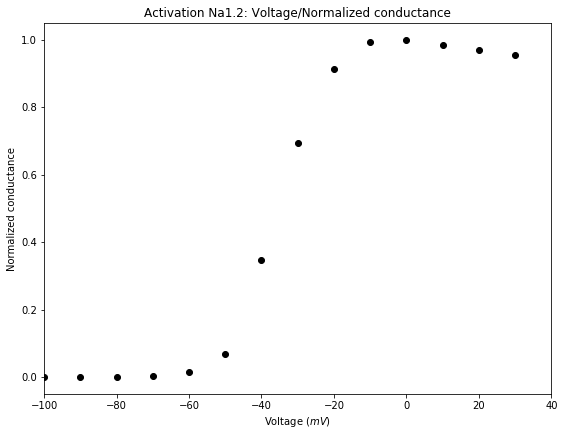

[Vector[27],
 Vector[27],
 Vector[27],
 Vector[27],
 Vector[27],
 Vector[27],
 Vector[27],
 Vector[27],
 Vector[27],
 Vector[27],
 Vector[27],
 Vector[27],
 Vector[27],
 Vector[27],
 Vector[27],
 Vector[27]]

(Vector[37],
 array([-120, -110, -100,  -90,  -80,  -70,  -60,  -50,  -40,  -30,  -20,
         -10,    0,   10,   20,   30]),
 [[-7.040829506108157e-08,
   -7.041506801317054e-08,
   -7.041821393820815e-08,
   -7.041806776306842e-08,
   -7.042041074487074e-08,
   -7.042514574944306e-08,
   -7.042142354184829e-08,
   -7.042127934277369e-08,
   -7.042127496464883e-08,
   -7.042127442097995e-08,
   -7.042127444403847e-08,
   -7.042127446573543e-08,
   -7.042127448629085e-08,
   -7.042127450586194e-08,
   -7.042127452456537e-08,
   -7.042127454249122e-08,
   -7.042127455971173e-08,
   -7.042851926970624e-08,
   -7.042851871731317e-08,
   -7.04285187327448e-08,
   -7.042851874766684e-08,
   -7.04285187621151e-08,
   -7.04285187761221e-08,
   -7.042851878971756e-08,
   -7.042851880292879e-08,
   -7.042851881578087e-08,
   -7.0428518828297e-08,
   -7.042851884049856e-08,
   -7.042851885240536e-08,
   -7.04285188640357e-08,
   -7.042851887540655e-08,
   -7.042851888653361e-08,
   -7.042851889

<TopLevelHocInterpreter>

In [3]:
### Activation ###

display(activationNa12("plotActivation"));

display(activationNa12("genActivation"));

display(activationNa12("geth"));


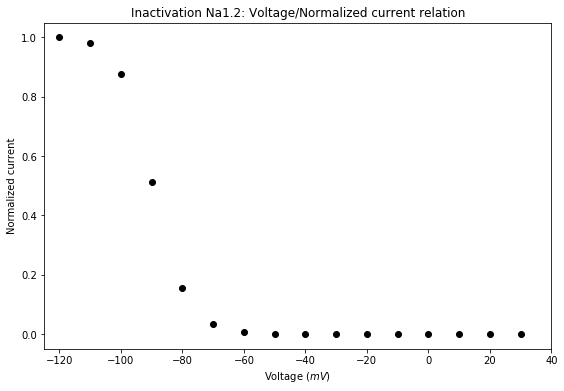

None

(Vector[56],
 array([-120, -110, -100,  -90,  -80,  -70,  -60,  -50,  -40,  -30,  -20,
         -10,    0,   10,   20,   30]),
 [[-6.660442865110056e-08,
   -6.661149275488031e-08,
   -6.66146443594293e-08,
   -6.661449818099719e-08,
   -6.661684044973275e-08,
   -6.661433189550956e-08,
   -6.661785366903766e-08,
   -6.661771088931914e-08,
   -6.661770466246523e-08,
   -6.661770468586663e-08,
   -6.661770470767874e-08,
   -6.661770472820286e-08,
   -6.661770474764716e-08,
   -6.661770476616034e-08,
   -6.661770478385277e-08,
   -6.661770480080964e-08,
   -6.66177048170993e-08,
   -6.661770483277849e-08,
   -6.661770484789564e-08,
   -6.661770486249312e-08,
   -6.661770487660855e-08,
   -6.661770489027581e-08,
   -6.661770490352566e-08,
   -6.661770491638622e-08,
   -6.661770492888332e-08,
   -6.66177049410407e-08,
   -6.661770495288026e-08,
   -6.661770496442227e-08,
   -6.661770497568545e-08,
   -6.661770498668711e-08,
   -6.661770499744332e-08,
   -6.661770500796891e-08,
   -6.661770

In [4]:
### Inactivation ###

display(inactivationNa12("plotInactivation"))

display(inactivationNa12("genInactivation"))

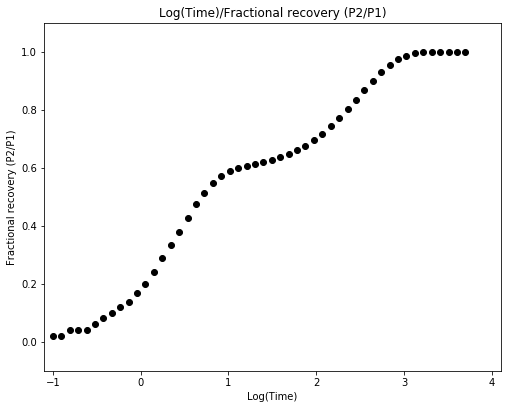

None

Vector[70]

([0.020501181173113354,
  0.020501181173113354,
  0.04155478315239561,
  0.04155478315239561,
  0.04155478315239561,
  0.06184524255250733,
  0.08139161532852102,
  0.10022128698608641,
  0.11836069630359278,
  0.13583531386617598,
  0.16888741036243876,
  0.19956321281733433,
  0.24149461952277557,
  0.29059122839491763,
  0.3329027798775535,
  0.37768172100817865,
  0.4279612861775363,
  0.47620165652456375,
  0.5141296373469824,
  0.5468407489205953,
  0.5722846137341789,
  0.5885923783147781,
  0.5995672111755793,
  0.6068675091981574,
  0.6128484962879419,
  0.6193354057307664,
  0.6268290640010202,
  0.6360300035264179,
  0.6471790379942128,
  0.6606360084159316,
  0.6766329700676413,
  0.6955483007079996,
  0.7175984262803516,
  0.7429290423465014,
  0.771310342810462,
  0.8023420151604801,
  0.8351988200736227,
  0.8686458650488116,
  0.9010447412688715,
  0.9304469347304679,
  0.9552085843286848,
  0.9741306131030661,
  0.9869475603246749,
  0.9944409954902871,
  0.99808202307

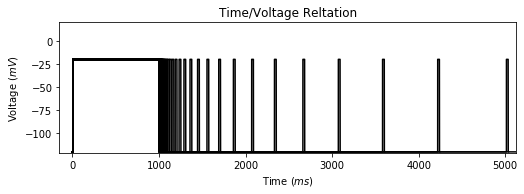

None

Vector[85]

In [5]:
### Recovery from Inactivation ###

display(recInactTauNa12("plotRecInact"))

display(recInactTauNa12("genRecInactTau"))

display(recInactTauNa12("genRecInactTauCurve"))

display(recInactTauNa12("plotRecInactProcedure"))

display(recInactTauNa12("genRecInact"))